In [ ]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.special
import scipy.stats as stats
import pymc3 as pm
import seaborn as sns
import pandas as pd

def credible_interval_from_samples(samples, prob):
    """`samples` can be an nd array. Assume that all of the dimensions 
    except for the last index parameters while the last (rightmost) 
    dimension indexes the samples."""
    samples_sorted = sort(samples, axis=-1)
    N_samples = samples.shape[-1]
    index = int(N_samples*(1 - prob)/2)
    lower = samples_sorted[..., index]
    upper = samples_sorted[..., -index]
    return lower, upper

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Question 1
A lepidopterist contacts you for help in characterizing the movement behavior of a certain species of butterfly. During daylight hours, these butterflies flutter about seamingly at random, but over time they very slowly migrate, on average, in a roughly north easterly direction. It is very difficult to determine the speed, they say, based on watching them move. They can track the average migration velocity over the timescale of weeks, but they want to know what their daytime migration velocity is in this particular region. 

They tell you that they have been able to use special cameras to track the motion of individual butterflies over approximately two minutes, with positions sampled roughly once per second. After agreeing to help, you recieve an email with a CSV file (you can find the file at `Data/butterfly.csv`). 

Before hanging up, they mention a curious observation. "I can't quite explain how," they explain, "but when I watch them move it seems like there are two types of butterfly." They believe that there might be two different "modes" of flying behavior that causes some subtle change in their motion, but they cannot tell you any more than that.


# A
Load the data from the file `butterfly.csv` in the data folder into a Pandas dataframe. There are 4 colunns: `id`, `time`, `x`, and `y`. The positions are all in units of meters, and the times are in units of seconds.

The `id` column contains a unique integer for each butterfly. (i.e., the data for the butterfly with `id=1` could be found with `b1 = data[data['id'] == 1]`. Look through the position series of each butterfly and locate any that have been corrupted, improperly formated, or have incomplete data. Filter out any that you find, and create a new dataframe with the cleaned data.

# B
  1. Plot the trajectories of all the butterflies $x$ vs $y$. 
  2. Plot the $x$ and $y$ positions of five random butterflies as a function of time. Put each plot in a different subplot. 

# C
Create a new dataframe with the following columns: butterfly ID number and two new columns containing $\Delta x_t = x_{t} - x_{t-1}$ and $\Delta y_t = y_{t} - y_{t-1}$. This will be your primary dataset for the remaining parts of the exam.

# D
Plot a probability density function (using a kernel density estimator) for both $\Delta x$ and $\Delta y$.

# E 
Using the resulting plot from the previous part, make a guess about what distribution you should use as a model of $\Delta x$ and $\Delta y$. **(You should assume that all of the $\Delta x$ and $\Delta y$ are independent.)** Should you use different parameters in the distribution for $\Delta x$ and $\Delta y$? You should be able to write down a simple formula for the migration velocity as a function of these parameters (there is more than one way this part could be answered, you just need one that works).

# F
Propose informative priors for your parameters, create prior predictive plots, and describe the reasoning you used to justify your choices.

# G
Use MCMC sampling (use 4 chains each with 1000 samples) to estimate the posterior distribution for the velocity. Plot the corresponding posterior probability density function for the velocity (using a KDE). Label the axes and make it look nice.

# A
## 20 points
Load the data from the file `butterfly.csv` in the data folder into a Pandas dataframe. There are 4 colunns: `id`, `time`, `x`, and `y`. The positions are all in units of meters, and the times are in units of seconds.

The `id` column contains a unique integer for each butterfly. (i.e., the data for the butterfly with `id=1` could be found with `b1 = data[data['id'] == 1]`. Look through the position series of each butterfly and locate any that have been corrupted, improperly formated, or have incomplete data. Filter out any that you find, and create a new dataframe with the cleaned data.

In [ ]:
## A
df = pd.read_csv('MATH509-Fall2021-JupyterNotebooks/Data/butterfly.csv', index_col=0)
data = df[df['id'] > 1]

# B
## 15 points
  1. Plot the trajectories of all the butterflies $x$ vs $y$. 
  2. Plot the $x$ and $y$ positions of five random butterflies as a function of time. Put each plot in a different subplot. 

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


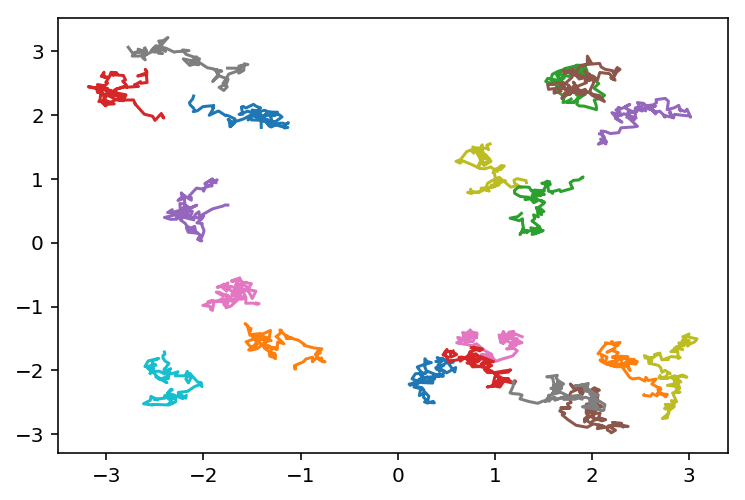

In [ ]:
## B
for _id, group in data.groupby('id'):
    plot(group['x'], group['y'])

In [ ]:
data

,id,time,x,y
100,2.0,0.0,0.249175,-2.122967
101,2.0,1.0,0.283784,-2.109450
102,2.0,2.0,0.380253,-2.131093
103,2.0,3.0,0.366921,-2.071878
104,2.0,4.0,0.391982,-2.097166
...,...,...,...,...
1995,20.0,95.0,2.788192,-2.632676
1996,20.0,96.0,2.773551,-2.743640
1997,20.0,97.0,2.723339,-2.751803
1998,20.0,98.0,2.790746,-2.668303


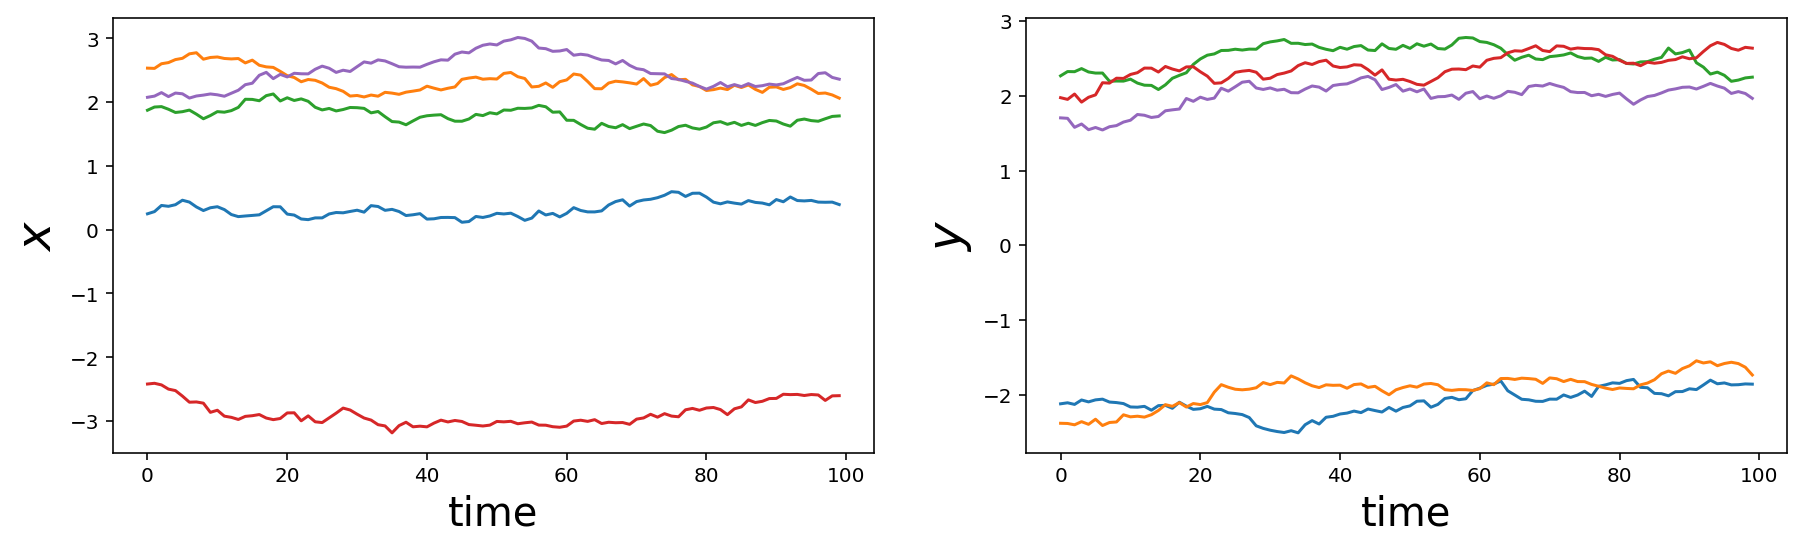

In [ ]:
fig = figure(1, [15, 4])

ax1 = fig.add_subplot(121)
xlabel('time', fontsize=20)
ylabel(r'$x$', fontsize=24)

ax2 = fig.add_subplot(122)
xlabel('time', fontsize=20)
ylabel(r'$y$', fontsize=24)

time = arange(100)

for _id, group in df2.groupby('id'):
    ax1.plot(time, group['x'])
    ax2.plot(time, group['y'])
    if _id > 5:
        break

# C
## 10 points
Create a new dataframe with the following columns: butterfly ID number and two new columns containing $\Delta x_t = x_{t} - x_{t-1}$ and $\Delta y_t = y_{t} - y_{t-1}$. This will be your primary dataset for the remaining parts of the exam.

In [ ]:
## C
df2 = df[df['id'] > 1]
data_dx = []
data_dy = []
for n, g in df2.groupby('id'):
    data_dx.extend(diff(g['x']))
    data_dy.extend(diff(g['y']))
data_dx = array(data_dx)
data_dy = array(data_dy)

## Should also create a dataframe

# D
## 15 points
Plot a probability density function (using a kernel density estimator) for both $\Delta x$ and $\Delta y$.

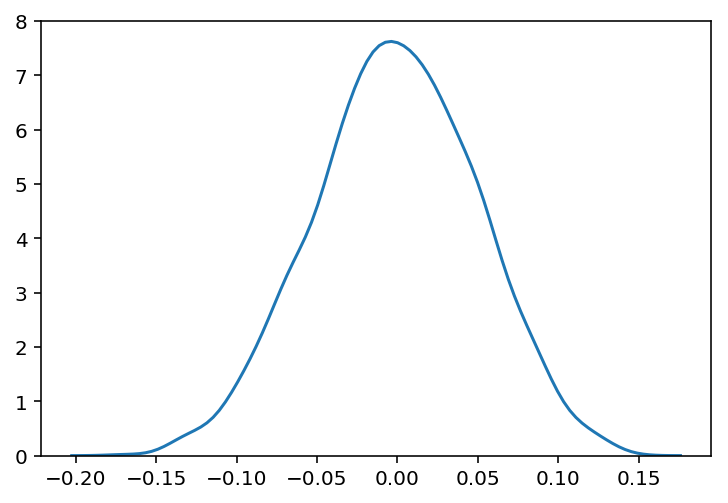

In [ ]:
## D
sns.kdeplot(data_dx)

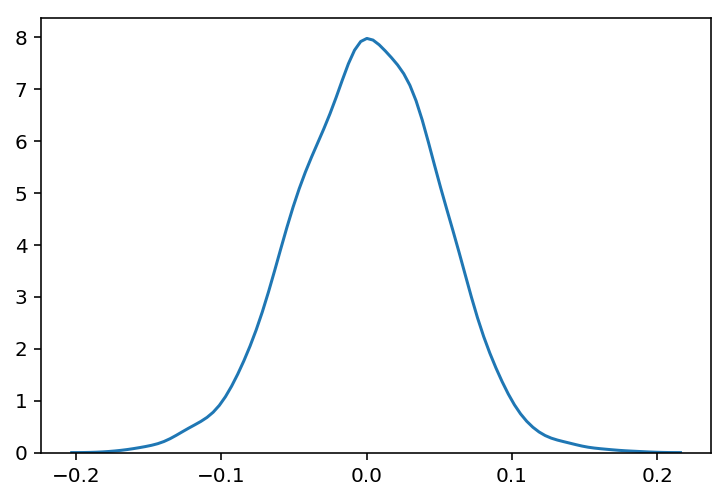

In [ ]:
sns.kdeplot(data_dy)

# E
## 10 points
Using the resulting plot from the previous part, make a guess about what distribution you should use as a model of $\Delta x$ and $\Delta y$. **(You should assume that all of the $\Delta x$ and $\Delta y$ are independent.)** Should you use different parameters in the distribution for $\Delta x$ and $\Delta y$? You should be able to write down a simple formula for the migration velocity as a function of these parameters (there is more than one way this part could be answered, you just need one that works).

## Answer:
This is a possible model. Other models might also work
\begin{align*}
    \Delta x &\sim \text{Normal}(\mu_x, \sigma) \\
    \Delta y &\sim \text{Normal}(\mu_y, \sigma) \\
    \mu_x &= r\cos(\theta) \\
    \mu_y &= r\sin(\theta) \\
    r &\sim \text{Exponential}(0.01) \\
    \theta &\sim \text{Normal}(\pi/4, \pi/8) \\
    \sigma &\sim \text{Exponential}(1)
\end{align*}

# F 
## 20 points
Propose informative priors for your parameters, create prior predictive plots, and describe the reasoning you used to justify your choices.

-------------------
Full points if reasonable, has a prior predictive plot, and mentions something about the northeast direction given in the problem description.

# G
## 10 points
Use MCMC sampling (use 4 chains each with 1000 samples) to estimate the posterior distribution for the velocity. Plot the corresponding posterior probability density function for the velocity (using a KDE). Label the axes and make it look nice.

In [ ]:
standardization_factor = data_dx.std()
with pm.Model() as model_1:
    logsigma = pm.Normal('logsigma', mu=0, sd=1.)
    theta = pm.Normal('theta', mu=pi/4, sd=pi/8)
    speed = pm.Exponential('speed', 0.01/standardization_factor)
    mux = pm.Deterministic('mux', speed*cos(theta))
    muy = pm.Deterministic('muy', speed*sin(theta))
    dx = pm.Normal('dx', mu=mux, sd=exp(logsigma), observed=data_dx/standardization_factor)
    dy = pm.Normal('dy', mu=muy, sd=exp(logsigma), observed=data_dy/standardization_factor)
    _mcmc_samples = pm.sample(1000, tune=1000)
mcmc_samples = pm.trace_to_dataframe(_mcmc_samples)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # Remove the CWD from sys.path while we load stuff.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [speed, theta, logsigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.


mean: 0.9548406911154895
median 0.9686744498067599
standard deviation: 0.3939450178076202
credible interval (0.85): (array(0.38931347), array(1.5126379))
truth: 1.0471975511965976


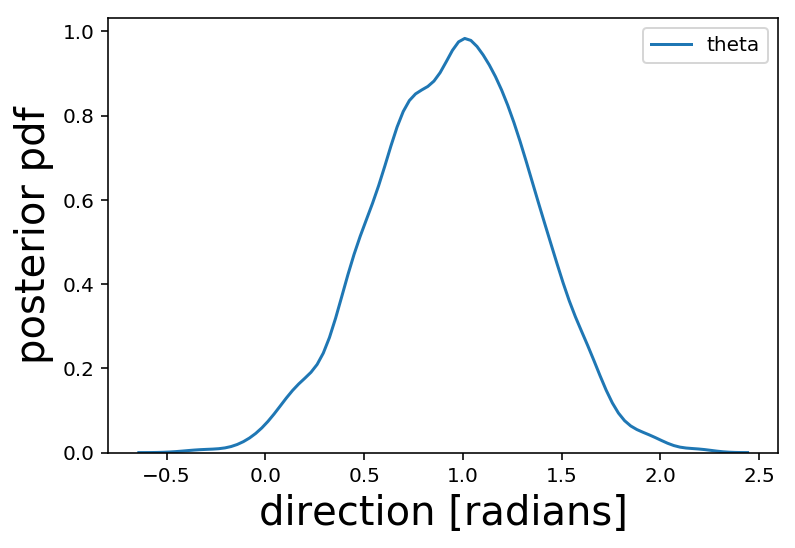

In [ ]:
sns.kdeplot(mcmc_samples['theta'])
xlabel('direction [radians]', fontsize=20)
ylabel('posterior pdf', fontsize=20)
print('mean:', mcmc_samples['theta'].mean())
print('median', mcmc_samples['theta'].median())
print('standard deviation:', mcmc_samples['theta'].std())
print('credible interval (0.85):', credible_interval_from_samples(mcmc_samples['theta'], 0.85))
print('truth:', pi/3)

mean: 0.001168818711864858
median 0.0010311697629660048
standard deviation: 0.0008156322264550234
credible interval (0.85): (array(0.00015614), array(0.00248688))
truth: 0.0015


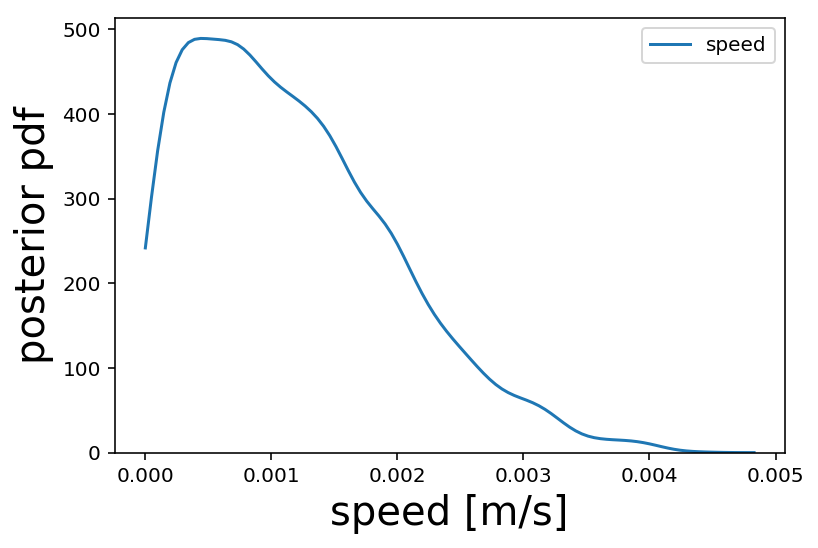

In [ ]:
speed = mcmc_samples['speed']*standardization_factor
sns.kdeplot(speed, clip=(0, inf))
xlabel('speed [m/s]', fontsize=20)
ylabel('posterior pdf', fontsize=20)
print('mean:', speed.mean())
print('median', speed.median())
print('standard deviation:', speed.std())
print('credible interval (0.85):', credible_interval_from_samples(speed, 0.85))
print('truth:', 0.0015)